In [1]:
import pandas as pd
df = pd.read_csv("../data/med_adherence_synthetic.csv")
df.head()


,patient_id,age,gender,chronic_conditions,num_meds,refill_gap_days,prior_year_adherence,mental_health_flag,copay_tier,plan_type,adherent
0,1,69,M,0,1,3,100.0,0,high,Commercial,1
1,2,32,M,1,4,37,61.0,0,medium,Commercial,0
2,3,89,M,2,2,26,60.7,1,medium,Medicare,0
3,4,78,F,1,7,14,89.2,0,medium,Medicaid,0
4,5,38,F,2,2,13,89.1,0,medium,Commercial,1


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/med_adherence_synthetic.csv")
df.head()


,patient_id,age,gender,chronic_conditions,num_meds,refill_gap_days,prior_year_adherence,mental_health_flag,copay_tier,plan_type,adherent
0,1,69,M,0,1,3,100.0,0,high,Commercial,1
1,2,32,M,1,4,37,61.0,0,medium,Commercial,0
2,3,89,M,2,2,26,60.7,1,medium,Medicare,0
3,4,78,F,1,7,14,89.2,0,medium,Medicaid,0
4,5,38,F,2,2,13,89.1,0,medium,Commercial,1


In [3]:
X = df.drop(columns=["adherent"])
y = df["adherent"]


In [4]:
categorical_cols = ["gender", "copay_tier", "plan_type"]
numeric_cols = [col for col in X.columns if col not in categorical_cols]
categorical_cols, numeric_cols


(['gender', 'copay_tier', 'plan_type'],
 ['patient_id',
  'age',
  'chronic_conditions',
  'num_meds',
  'refill_gap_days',
  'prior_year_adherence',
  'mental_health_flag'])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [6]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)


In [7]:
log_reg_model = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000))
])

log_reg_model.fit(X_train, y_train)

y_pred_lr = log_reg_model.predict(X_test)
y_prob_lr = log_reg_model.predict_proba(X_test)[:, 1]

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print("AUC:", roc_auc_score(y_test, y_prob_lr))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       796
           1       0.61      0.25      0.35       204

    accuracy                           0.81      1000
   macro avg       0.72      0.60      0.62      1000
weighted avg       0.79      0.81      0.78      1000

AUC: 0.7693553552074096


C:\Users\Ali Hasan\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [8]:
rf_model = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42
    ))
])

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, y_prob_rf))


Random Forest Results:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       796
           1       0.61      0.25      0.36       204

    accuracy                           0.81      1000
   macro avg       0.72      0.60      0.62      1000
weighted avg       0.79      0.81      0.78      1000

AUC: 0.7569711301606069


<Figure size 800x600 with 0 Axes>

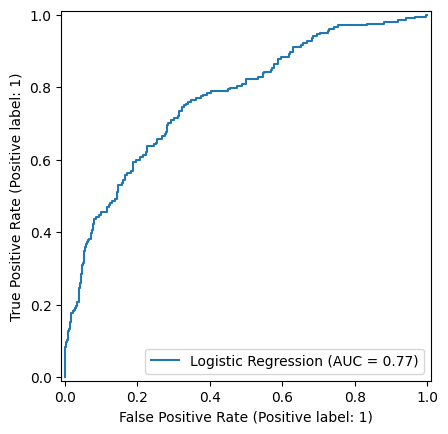

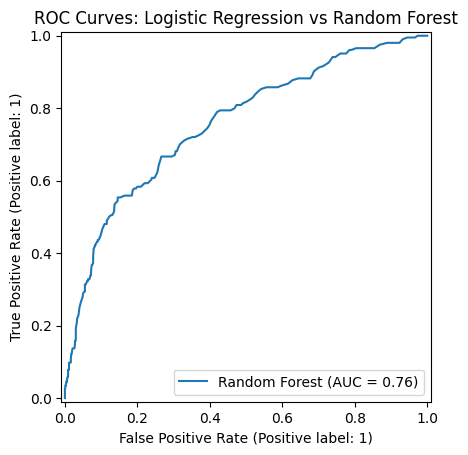

In [9]:
plt.figure(figsize=(8,6))
RocCurveDisplay.from_predictions(y_test, y_prob_lr, name="Logistic Regression")
RocCurveDisplay.from_predictions(y_test, y_prob_rf, name="Random Forest")
plt.title("ROC Curves: Logistic Regression vs Random Forest")
plt.show()


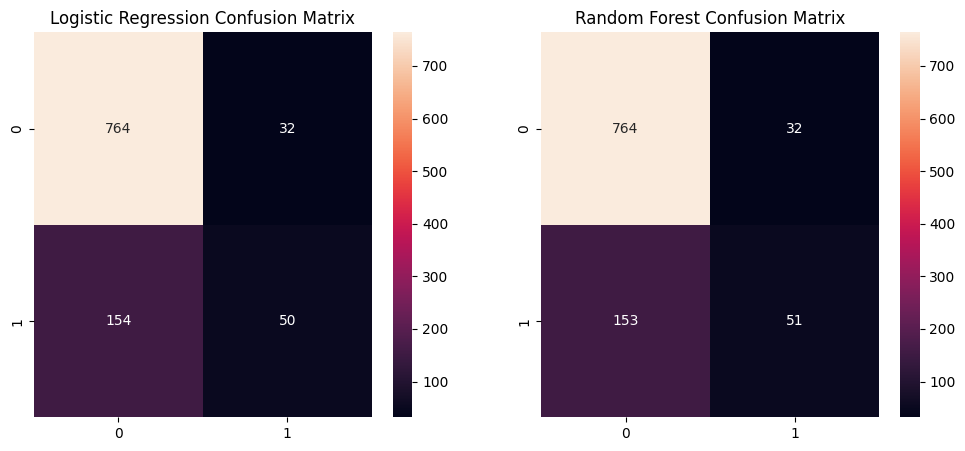

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', ax=ax[0])
ax[0].set_title("Logistic Regression Confusion Matrix")

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', ax=ax[1])
ax[1].set_title("Random Forest Confusion Matrix")

plt.show()


In [11]:
import joblib

joblib.dump(log_reg_model, "../models/logreg_adherence.pkl")
joblib.dump(rf_model, "../models/rf_adherence.pkl")


['../models/rf_adherence.pkl']